<a href="https://colab.research.google.com/github/mkilina/deeplearning/blob/main/chit_chat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install youtokentome

In [4]:
!pip3 install tensorflow_text>=2.0.0rc0

## Try AI Hub https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/retrieval_with_tf_hub_universal_encoder_qa.ipynb#scrollTo=J0xTw2w3UViK

In [5]:
%%capture
#@title Setup Environment
# Install the latest Tensorflow version.
!pip install -q tensorflow_text
!pip install -q simpleneighbors[annoy]
!pip install -q nltk
!pip install -q tqdm

In [6]:
import math
import numpy as np
import pandas as pd

import random
import json
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from functools import reduce
from matplotlib import pyplot as plt

#import youtokentome as yttm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import json
import nltk
import os
import pprint
import random
import simpleneighbors
import urllib
from IPython.display import HTML, display
from tqdm.notebook import tqdm

import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
from tensorflow_text import SentencepieceTokenizer

nltk.download('punkt')


def download_squad(url):
  return json.load(urllib.request.urlopen(url))

def extract_sentences_from_squad_json(squad):
  all_sentences = []
  for data in squad['data']:
    for paragraph in data['paragraphs']:
      sentences = nltk.tokenize.sent_tokenize(paragraph['context'])
      all_sentences.extend(zip(sentences, [paragraph['context']] * len(sentences)))
  return list(set(all_sentences)) # remove duplicates

def extract_questions_from_squad_json(squad):
  questions = []
  for data in squad['data']:
    for paragraph in data['paragraphs']:
      for qas in paragraph['qas']:
        if qas['answers']:
          questions.append((qas['question'], qas['answers'][0]['text']))
  return list(set(questions))

def output_with_highlight(text, highlight):
  output = "<li> "
  i = text.find(highlight)
  while True:
    if i == -1:
      output += text
      break
    output += text[0:i]
    output += '<b>'+text[i:i+len(highlight)]+'</b>'
    text = text[i+len(highlight):]
    i = text.find(highlight)
  return output + "</li>\n"

def display_nearest_neighbors(query_text, answer_text=None):
  query_embedding = model.signatures['question_encoder'](tf.constant([query_text]))['outputs'][0]
  search_results = index.nearest(query_embedding, n=num_results)

  if answer_text:
    result_md = '''
    <p>Random Question from SQuAD:</p>
    <p>&nbsp;&nbsp;<b>%s</b></p>
    <p>Answer:</p>
    <p>&nbsp;&nbsp;<b>%s</b></p>
    ''' % (query_text , answer_text)
  else:
    result_md = '''
    <p>Question:</p>
    <p>&nbsp;&nbsp;<b>%s</b></p>
    ''' % query_text

  result_md += '''
    <p>Retrieved sentences :
    <ol>
  '''

  if answer_text:
    for s in search_results:
      result_md += output_with_highlight(s, answer_text)
  else:
    for s in search_results:
      result_md += '<li>' + s + '</li>\n'

  result_md += "</ol>"
  display(HTML(result_md))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
import json
questions = []
answers = []

# with open("/content/drive/MyDrive/fb2-000024-030559.jsonl") as f:
#   for line in f:
#     dialogs = json.loads(line).get("dialogues")
#     for d in dialogs:
#       answers.append(d[1:])
#       questions.append(d[:len(d)-1])

# with open("/content/drive/MyDrive/fb2-060424-074391.jsonl") as f:
#   for line in f:
#     dialogs = json.loads(line).get("dialogues")
#     for d in dialogs:
#       answers.append(d[1:])
#       questions.append(d[:len(d)-1])

with open("/content/drive/MyDrive/fb2-074392-091839.jsonl") as f:
  for line in f:
    dialogs = json.loads(line).get("dialogues")
    for d in dialogs:
      answers.append(d[1:])
      questions.append(d[:len(d)-1])

# with open("/content/drive/MyDrive/fb2-030560-060423.jsonl") as f:
#   for line in f:
#     dialogs = json.loads(line).get("dialogues")
#     for d in dialogs:
#       answers.append(d[1:])
#       questions.append(d[:len(d)-1])

# with open("/content/drive/MyDrive/lost.json") as f: #нерусский
#   for line in f:
#     dialogs = json.loads(line).get("dialogues")
#     for d in dialogs:
#       answers.append(d[1:])
#       questions.append(d[:len(d)-1])

#answers = reduce(lambda x,y: x+y, answers)
#questions = reduce(lambda x,y: x+y, questions)

In [9]:
%%time
answers = reduce(lambda x,y: x+y, answers[:10000])

CPU times: user 1.86 s, sys: 56.3 ms, total: 1.92 s
Wall time: 1.93 s


In [10]:
%%time
questions = reduce(lambda x,y: x+y, questions[:10000])

CPU times: user 2.09 s, sys: 177 ms, total: 2.27 s
Wall time: 2.27 s


In [11]:
sentences = list(zip(questions, answers))

In [12]:
len(answers), len(questions)

(50757, 50757)

In [72]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual-qa/3"
model = hub.load(module_url)

In [73]:
batch_size = 100

encodings = model.signatures['response_encoder'](
  input=tf.constant([sentences[0][0]]),
  context=tf.constant([sentences[0][1]]))
index = simpleneighbors.SimpleNeighbors(
    len(encodings['outputs'][0]), metric='angular')

print('Computing embeddings for %s sentences' % len(sentences))
slices = zip(*(iter(sentences),) * batch_size)
num_batches = int(len(sentences) / batch_size)
for s in tqdm(slices, total=num_batches):
  response_batch = list([r for r, c in s])
  context_batch = list([r for r, c in s])
  encodings = model.signatures['response_encoder'](
    input=tf.constant(response_batch),
    context=tf.constant(context_batch)
  )
  for batch_index, batch in enumerate(response_batch):
    index.add_one(batch, encodings['outputs'][batch_index])

index.build()

Computing embeddings for 50757 sentences


In [74]:
query = random.choice(questions)

In [76]:
query_embedding = model.signatures['question_encoder'](
            tf.constant(query))
query

'Что делать?'

In [77]:
num_results = 10

query = random.choice(questions)
display_nearest_neighbors(query, query)

In [1]:
query = random.choice(questions)
display_nearest_neighbors(query, query)

NameError: ignored

In [2]:
query = random.choice(questions)
display_nearest_neighbors(query, query)

NameError: ignored

## Try my own model

In [12]:
dataset = []
dataset += list(zip(questions[:int(len(questions)/2)], answers[:int(len(questions)/2)]))

In [13]:
import random
sub_answers = answers[int(len(questions)/2):]
random.shuffle(sub_answers)
dataset += list(zip(questions[int(len(questions)/2):], sub_answers))

In [14]:
dataset[26000:26005]

[('Далеко не уедут,', 'Вы предпочитаете служить Алехандро?'),
 ('Знаешь, может, к лучшему, что ты не успел сделать и второе колесо. Одно можно считать случайностью. Что там у тебя в этой чупаге?',
  'Что? Почему? Что случилось?'),
 ('А что в ней такое может быть? Чупаги не видел?',
  'Марья я, из двенадцатой,'),
 ('Нет, но чем же ты... того...',
  'Там!.. Прямо против нас… берег… островки… подводные скалы.'),
 ('Ничего я не того! Или ты что видел?',
  'Он планирует пустить каждого вампира в городе убивать людей в этот Хэллоуин.')]

In [15]:
data = [(a, b, 1) for a, b in dataset[:int(len(questions)/2)]]

In [16]:
data += [(a, b, 0) for a, b in dataset[int(len(questions)/2):]]

In [17]:
import pandas as pd
dataset = pd.DataFrame(data)

In [18]:
dataset.columns = ['question', 'answer', 'target']

In [19]:
import string
dataset.question = dataset.question.map(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
dataset.answer = dataset.answer.map(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
dataset.head()

,question,answer,target
0,проныра3 подтяни хвост сейчас на нас будут гла...,так точно сэр,1
1,сенсоры регистрируют эскадрилью истребителей и...,сохраняйте строй разбойный эскадрон,1
2,сохраняйте строй разбойный эскадрон,неверные позывные сэр это мы разбойники с боль...,1
3,неверные позывные сэр это мы разбойники с боль...,хобби лейтенант это ты,1
4,хобби лейтенант это ты,вообщето,1


In [20]:
import youtokentome as yttm

In [21]:
dataset.question[5]

'хобби не хочешь объяснить что это за чушь'

In [22]:
with open('for_bpe.txt', 'w', encoding='utf-8') as f:
    for idx in range(len(dataset)):
      f.write(dataset.question[idx] + '\n')
        
vocab_size = 30_000
model_path = 'pretrained_bpe_lm.model'

In [23]:
%%time
yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

CPU times: user 1.32 s, sys: 428 ms, total: 1.74 s
Wall time: 1.2 s


In [24]:
tokenizer = yttm.BPE(model=model_path)

In [25]:
tokenizer.encode(dataset.question[2], bos=True, eos=True, 
    output_type=yttm.OutputType.SUBWORD)

['<BOS>', '▁сохра', 'няйте', '▁строй', '▁разбойный', '▁эскадрон', '<EOS>']

In [26]:
tokenizer.encode(dataset.question[2], bos=True, eos=True)

[2, 2540, 14976, 6544, 11662, 11748, 3]

In [27]:
records = dataset.to_records(index=False)
df = list(records)

In [28]:
df[:5]

[('проныра3 подтяни хвост сейчас на нас будут глазеть', 'так точно сэр', 1),
 ('сенсоры регистрируют эскадрилью истребителей идут на сближение скорость соответствует «крестокрылам» сигнал радара позволяет предположить модификацию «инкома т65»', 'сохраняйте строй разбойный эскадрон', 1),
 ('сохраняйте строй разбойный эскадрон', 'неверные позывные сэр это мы разбойники с большой дороги но через несколько минут мы вспомним про вежливость и назовем себя красной эскадрильей чтобы избежать путаницы мы', 1),
 ('неверные позывные сэр это мы разбойники с большой дороги но через несколько минут мы вспомним про вежливость и назовем себя красной эскадрильей чтобы избежать путаницы мы', 'хобби лейтенант это ты', 1),
 ('хобби лейтенант это ты', 'вообщето', 1)]

In [29]:
random.shuffle(df)
df[:5]

[('что совсем не с кем поиграть а куда делись подружки', 'во что поиграть нет он не хочет чтоб она стала шлюхой он водил ее в музей и объяснял что картины существуют для того чтобы в человеке вздрагивало сердце и хотелось чегото хорошего «чего» «раз спрашиваешь значит до тебя еще ничего не дошло» у нее вздрогнуло сердце у «апофеоза войны» но ничего хорошего не захотелось а хотелось уйти из музея раз и навсегда «эта картина против войны» «нет за надо очень любить смерть чтобы нарисовать столько черепов и остаться жить» сказал отец больше они в музей не ходили а она однажды попробовала нарисовать по памяти «апофеоз» ничего не вышло каждый череп превращался в ее воображении в живого человека и она не знала что делать с этим возникшим в ней живым который уже мертвый', 1),
 ('вот теперь я это и сам могу', 'слезно молю вас сударь упросите никиту акинфиевича отпустить меня на волю', 0),
 ('ты его задушишь', 'ты ее разглядел', 0),
 ('слезно молю вас сударь упросите никиту акинфиевича отпустить

In [30]:
len(df)

50757

In [31]:
batch_size = 21
batches = []
for i in range(0, len(df), batch_size):
  batches.append(df[i:i+batch_size])

In [32]:
df = df[:20000]

In [33]:
validation_start_index = int(len(df) * 0.2)
validation_start_index

4000

In [34]:
class Datasetter(torch.utils.data.Dataset):
  def __init__(self, data, pad=0, max_len=15):
        
        self.data = data
        self.pad = pad
        self.max_len = max_len
        
  def __len__(self):
      return len(self.data)
  
  def padding(self, text, length):
    text = text[:length]
    if len(text) < length:
      text += [self.pad] * (length - len(text))
    return text

  def __getitem__(self, index):
      item = self.data[index]

      xx = tokenizer.encode(item[0], bos=True, eos=True)
      zz = tokenizer.encode(item[1], bos=True, eos=True)
      yy = item[2]

      #max_len = int(np.percentile([len(item) for item in xx], 90))
      for i in range(len(xx)):
        xx = self.padding(xx, self.max_len)
        zz = self.padding(zz, self.max_len)

      xx = torch.tensor(xx).to(device)
      zz = torch.tensor(zz).to(device)
      yy = torch.tensor(yy).to(device)

      return xx, zz, yy

In [35]:
df[8]

('это еще зачем кто нас тут станет искать', 'оставь свои умные вопросы при себе просто делай что я говорю затем иди к фургону «газель» помой его снаружи и изнутри хорошенько помой мы оставим его здесь на бабкином участке', 1)

In [36]:
train_dataset = Datasetter(data=df[:-validation_start_index], max_len=32, pad=0)
validation_dataset = Datasetter(data=df[-validation_start_index:], max_len=32, pad=0)

len(train_dataset), len(validation_dataset)

(16000, 4000)

In [37]:
train_dataset[8]

(tensor([   2,  134,  286,  839,  345,  292,  471, 1740, 2375,    3,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([    2,  4004,   938, 22757,  2945,   154,   654,   424,  6103,   116,
           115,  1738,  2442,  1535,    93, 11672, 23083, 20579, 13574,    38,
          6199,   230,  7869,    96, 13886,  5125,  6199,   204,  8053,   230,
           392,   107]),
 tensor(1))

In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)

In [39]:
for x, z, y in train_loader:
    break

In [40]:
x.shape

torch.Size([32, 32])

In [41]:
x

tensor([[    2,   116,   775,  ...,     0,     0,     0],
        [    2,   333,   432,  ...,     0,     0,     0],
        [    2,   146,   230,  ...,     0,     0,     0],
        ...,
        [    2,  7645,   792,  ...,     0,     0,     0],
        [    2,   185,   367,  ...,     0,     0,     0],
        [    2, 17239,  1194,  ...,     0,     0,     0]])

In [42]:
progress_bar = tqdm(total=len(validation_loader.dataset), desc='Testing')

for x, z, y in validation_loader:
    progress_bar.update(x.size(0))
    
progress_bar.close()

In [43]:
s1 = "привет! как дела?"
s2 = "привет, спасибо, хорошо очень даже"
s3 = "очень рад за тебя"
s4 = "ты так мил"
#       [               batch0                ], [                batch1               ]
data = [(s1, s2, 1), (s2, s3, 1), (s3, s4, 1), (s4, s1, 0), (s1, s4, 0), (s1, s3, 0)]
dataset = Datasetter(data)

In [44]:
dataset.__getitem__(0) #batch1

(tensor([   2, 1689,    1,  165,  397,    1,    3,    0,    0,    0,    0,    0,
            0,    0,    0]),
 tensor([   2, 1689,    1,  926,    1,  482,  373,  477,    3,    0,    0,    0,
            0,    0,    0]),
 tensor(1))

In [156]:
class SupaDupaModel(torch.nn.Module):

  def __init__(self, vocab_size):
    super().__init__()

    self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,
                                              embedding_dim=256, padding_idx=0)
    
    self.lstm = torch.nn.LSTM(input_size=256, hidden_size=256, 
                              num_layers=3, dropout=0.35, batch_first=True, bidirectional=True)

    self.linear = torch.nn.Sequential(torch.nn.Linear(512, 128),
                                      torch.nn.ReLU(),
                                      torch.nn.Linear(128, 64))    
  def forward(self, x):

    x = self.embedding_layer(x)
    x, _ = self.lstm(x)
    x = self.linear(x)
    x = torch.mean(x, dim=1)
    return x

class SupaDupaWrapper(torch.nn.Module):

  def __init__(self, encoder):
    super().__init__()

    self.encoder = encoder
    self.linear = torch.nn.Linear(32, 32)
    # self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    # self.loss = torch.nn.CosineEmbeddingLoss()

  def forward(self, x, z):
    emb_x = self.encoder(x)
    emb_z = self.encoder(z)
    multiplied = []
    for ex, ez in zip(emb_x, emb_z):
      multiplied.append(torch.dot(ex, ez))
    multiplied = torch.tensor(multiplied)
    pred = self.linear(multiplied)
    # loss = self.loss(emb_x, emb_z)
    # pred = self.cos(emb_x, emb_z, y)
    # similarity = (emb_x * emb_z).sum(dim=1).unsqueeze(-1)
    # pred = self.linear(similarity)

    return torch.sigmoid(pred)

### Toy dataset

In [157]:
x = torch.randint(512, (32, 64))
z = torch.randint(512, (32, 64))
y = torch.randint(2, (32,))

encoder = SupaDupaModel(vocab_size=vocab_size)
wrapper = SupaDupaWrapper(encoder)
criterion = torch.nn.CosineEmbeddingLoss()

pred = wrapper(x, z)
# loss = criterion(emb_x, emb_z, y)
pred

tensor([0.5225, 0.5104, 0.5510, 0.4817, 0.4856, 0.5476, 0.4680, 0.4811, 0.4655,
        0.5661, 0.4945, 0.4588, 0.4728, 0.5154, 0.5258, 0.5508, 0.4736, 0.5543,
        0.5227, 0.4748, 0.4482, 0.4916, 0.5417, 0.4810, 0.4825, 0.4772, 0.4975,
        0.4939, 0.4959, 0.5668, 0.4937, 0.4617], grad_fn=<SigmoidBackward>)

In [158]:
from sklearn.metrics import roc_auc_score
epochs = 10
encoder = SupaDupaModel(vocab_size=vocab_size)
model = SupaDupaWrapper(encoder)
# определяем функцию потерь — бинарную кросс-энтропию
criterion = torch.nn.BCELoss()
# определяем алгоритм оптимизации Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(x, z)
    loss = criterion(predictions.to(torch.float32), y.to(torch.float32))
    print(loss)
    # вычисляем градиенты
    loss.backward()
    # обновляем параметры
    optimizer.step()

predictions = model(x, z)
print(roc_auc_score(y, predictions.detach().numpy()))

tensor(0.6966, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6654, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6352, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6060, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5779, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5507, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5248, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4999, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4760, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4532, grad_fn=<BinaryCrossEntropyBackward>)
1.0


In [159]:
criterion(predictions.to(torch.float32), y.to(torch.float32))

tensor(0.4312, grad_fn=<BinaryCrossEntropyBackward>)

In [160]:
y

tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0])

Все работает нормально, loss уменьшается

### Normal dataset

In [161]:
encoder = SupaDupaModel(vocab_size=vocab_size)
model = SupaDupaWrapper(encoder)
model.to(device)

SupaDupaWrapper(
  (encoder): SupaDupaModel(
    (embedding_layer): Embedding(30000, 256, padding_idx=0)
    (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.35, bidirectional=True)
    (linear): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=32, bias=True)
  (cos): CosineSimilarity()
  (loss): CosineEmbeddingLoss()
)

In [162]:
with torch.no_grad():
    pred = model(x, z)

In [163]:
pred.shape

torch.Size([32])

In [164]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [165]:
def basic_train(model, optimizer, criterion, x, z, y):
    model.train()
    predictions = model.forward(x, z)
    loss = criterion(predictions.to(torch.float32), y.to(torch.float32))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
         
    return loss

def basic_validate(model, criterion, x, z, y):
    model.eval()
    with torch.no_grad():
        predictions = model.forward(x, z)
        
    loss = criterion(predictions.to(torch.float32), y.to(torch.float32))
    return loss

def basic_iterate(model, t_loader, v_loader, epochs, optimizer, criterion, last_n_losses=500):
    losses = []
    val_losses = []
    
    prev_val_loss = 100000000
    for n_epoch in range(epochs):
        progress_bar = tqdm(total=len(t_loader), desc=f'Epoch {n_epoch + 1} of {epochs}')
        for x, z, y in t_loader:  
            x = x.to(device)
            z = z.to(device)
            loss = basic_train(model, optimizer, criterion, x, z, y)        
            losses.append(loss.detach().numpy())        
            if len(losses) > 1:
              progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]))    
              progress_bar.update()    
        progress_bar.close()

        for x, z, y in v_loader:
            loss = basic_validate(model, criterion, x, z, y)
            val_losses.append(loss.detach().numpy()) 

        curr_loss = np.mean(val_losses)
        print("\nCurr val loss: ", curr_loss)

        if curr_loss < prev_val_loss:
            torch.save(model.state_dict(), f'model')
            torch.save(optimizer.state_dict(), f'optimizer')
            prev_val_loss = curr_loss
        
    return losses

In [169]:
epoch_losses = basic_iterate(model, train_loader, validation_loader, 10, optimizer, criterion)



Curr val loss:  0.821169




Curr val loss:  0.82118917




Curr val loss:  0.82117856




Curr val loss:  0.82116777




Curr val loss:  0.8211719


KeyboardInterrupt: ignored

In [170]:
predictions = model(x, z)
print(roc_auc_score(y, predictions.detach().numpy()))

0.39453125


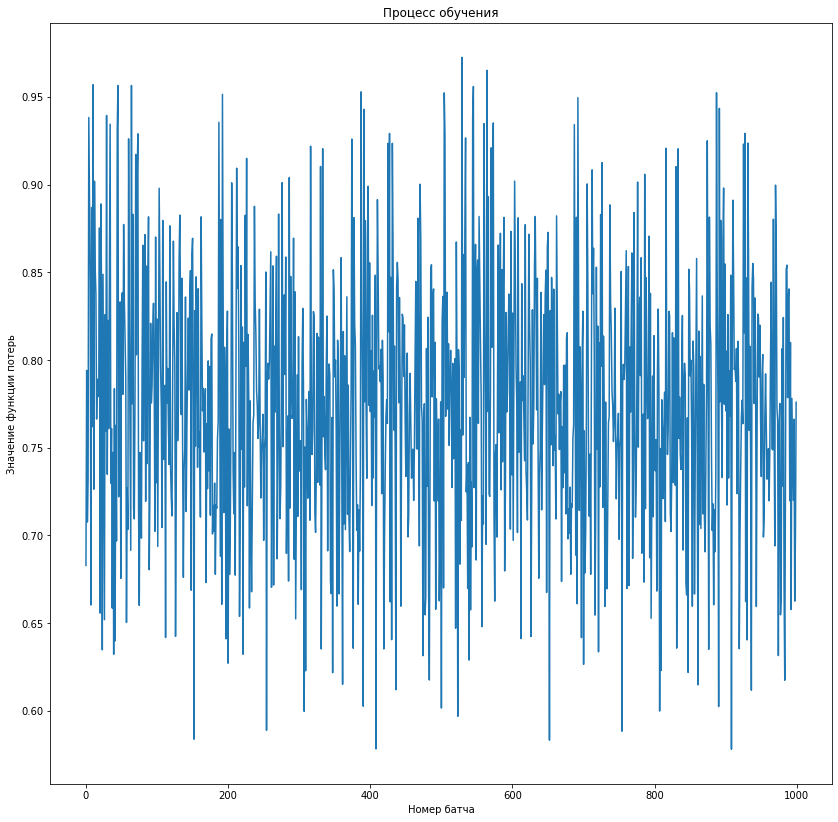

In [171]:
plt.figure(figsize=(14, 14))
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(epoch_losses)

Все работает ненормально :'(